In [1]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

c:\Users\prath\anaconda3\envs\spine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
    # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}

image_dir = "data/train_images/"

In [3]:
resize_transform= A.Compose([
    A.LongestMaxSize(max_size=224, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

def angle_of_line(x1, y1, x2, y2):
    return math.degrees(math.atan2(-(y2-y1), x2-x1))

def plot_img(img, coords_temp):
    # Plot img
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    h, w = img.shape
    
    # Kepoints as pairs
    p= coords_temp.groupby("level") \
                  .apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False) \
                  .reset_index(drop=False, name="vals")
    
    # Plot keypoints
    for _, row in p.iterrows():
        level = row['level']
        x = [_[0]*w for _ in row["vals"]]
        y = [_[1]*h for _ in row["vals"]]
        ax.plot(x, y, marker='o')
    ax.axis('off')
    plt.show()

def plot_5_crops(img, coords_temp):
    # Create a figure and axis for the grid
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    
    # Plot the crops
    p= coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False, name="vals")
    for idx, (_, row) in enumerate(p.iterrows()):
        # Copy of img
        img_copy= img.copy()
        h, w = img.shape

        # Extract Keypoints
        level = row['level']
        vals = sorted(row["vals"], key=lambda x: x[0])
        a,b= vals
        a= (a[0]*w, a[1]*h)
        b= (b[0]*w, b[1]*h)

        # Rotate
        rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
        transform = A.Compose([
            A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
        ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
        )

        t= transform(image=img_copy, keypoints=[a,b])
        img_copy= t["image"]
        a,b= t["keypoints"]
        
        # Crop + Resize
        img_copy= crop_between_keypoints(img_copy, a, b)
        img_copy= resize_transform(image=img_copy)["image"]
        
        # Plot
        ax = plt.subplot(gs[idx])
        ax.imshow(img_copy, cmap='gray')
        ax.set_title(level)
        ax.axis('off')
    plt.show()
    
    
def crop_between_keypoints(img, keypoint1, keypoint2):
    h, w = img.shape
    x1, y1 = int(keypoint1[0]), int(keypoint1[1])
    x2, y2 = int(keypoint2[0]), int(keypoint2[1])
    
    # Calculate bounding box around the keypoints
    left = int(min(x1, x2) + (w * 0.1))
    right = int(max(x1, x2) + (w * 0.1))
    top = int(min(y1, y2) - (h * 0.05))
    bottom = int(max(y1, y2) + (h * 0.05))
            
    # Crop the image
    return img[top:bottom, left:right]

-------------------------  STUDY_ID: 153831832, SERIES_ID: 2054214528  -------------------------


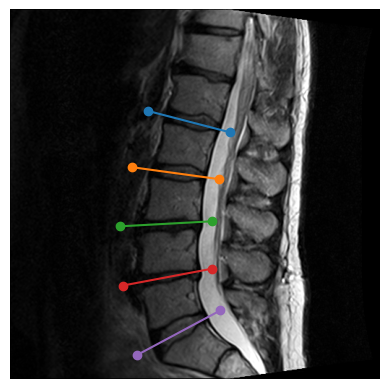

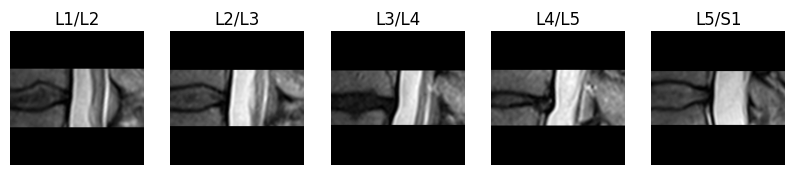

-------------------------  STUDY_ID: 200852737, SERIES_ID: 680111404  -------------------------


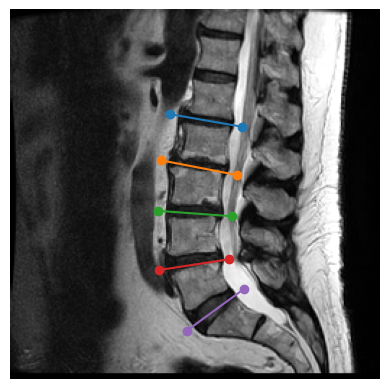

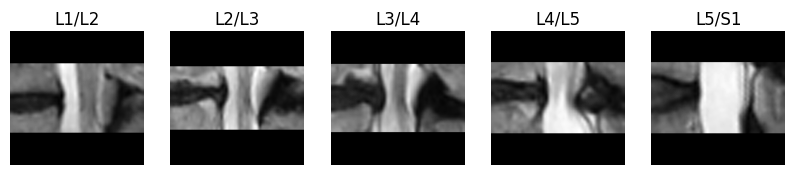

In [4]:
SEED= 10
N= 2

# Load series_ids
dfd= pd.read_csv("data/train_series_descriptions.csv")
dfd= dfd[dfd.series_description == "Sagittal T2/STIR"]
dfd= dfd.sample(frac=1, random_state=SEED).head(N)

# Load coords
coords= pd.read_csv("coords_rsna_improved.csv")
coords= coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
coords= coords[["series_id", "level", "side", "relative_x", "relative_y"]]

# Plot samples
for idx, row in dfd.iterrows():
    try:
        print("-"*25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-"*25)
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        
        # Img + Coords
        img= sag_t2["array"][len(sag_t2["array"])//2]
        coords_temp= coords[coords["series_id"] == row.series_id].copy()
        
        # Plot
        plot_img(img, coords_temp)
        plot_5_crops(img, coords_temp)
        
    except Exception as e:
        print(e)
        pass

In [5]:
def save_spine_crops(image_dir, output_dir):
    # Load series_ids
    dfd = pd.read_csv("data/train_series_descriptions.csv")
    dfd = dfd[dfd.series_description == "Sagittal T2/STIR"]

    # Load coords
    coords = pd.read_csv("coords_rsna_improved.csv")
    coords = coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
    coords = coords[["series_id", "level", "side", "relative_x", "relative_y"]]

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Process each series
    for _, row in tqdm(dfd.iterrows(), total=len(dfd)):
        study_id, series_id = row.study_id, row.series_id
        
        # Load DICOM stack
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(study_id), str(series_id)), plane="sagittal")
        
        # Select middle slice
        img = sag_t2["array"][len(sag_t2["array"])//2]
        coords_temp = coords[coords["series_id"] == series_id].copy()

        # Create study and series directories
        series_dir = os.path.join(output_dir, str(study_id), str(series_id))
        os.makedirs(series_dir, exist_ok=True)

        # Group coordinates by level
        p = coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False)

        try:
            p.columns = ['level', 'vals']  # Manually set the column name
        except:
            print(p.columns)
            continue
        # Process each level
        for _, level_row in p.iterrows():
            level = level_row['level'].replace('/', '_')
            vals = sorted(level_row["vals"], key=lambda x: x[0])

            # Check if we have two coordinate pairs
            if len(vals) != 2:
                print(f"Skipping level {level} for study {study_id}, series {series_id} due to insufficient coordinate pairs")
                continue

            a, b = vals
            h, w = img.shape
            a = (a[0]*w, a[1]*h)
            b = (b[0]*w, b[1]*h)

            # Rotate
            rotate_angle = angle_of_line(a[0], a[1], b[0], b[1])
            transform = A.Compose([
                A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
            ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

            t = transform(image=img, keypoints=[a,b])
            img_rotated = t["image"]
            a, b = t["keypoints"]

            # Crop and resize
            img_cropped = crop_between_keypoints(img_rotated, a, b)
            img_resized = resize_transform(image=img_cropped)["image"]

            # Save the crop
            output_path = os.path.join(series_dir, f"{level}.png")
            # print(f"Attempting to save image for study {study_id}, series {series_id}, level {level}")
            # print(f"Image shape: {img_resized.shape}")
            # print(f"Output path: {output_path}")

            # Create directories if they don't exist
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Save the crop
            cv2.imwrite(output_path, img_resized)

# Call the function
save_spine_crops(image_dir="data/train_images/", output_dir="crops224/")

 57%|█████▋    | 1127/1974 [07:26<04:36,  3.06it/s]

Skipping level L1_L2 for study 2492114990, series 1753543608 due to insufficient coordinate pairs
Skipping level L2_L3 for study 2492114990, series 1753543608 due to insufficient coordinate pairs
Skipping level L3_L4 for study 2492114990, series 1753543608 due to insufficient coordinate pairs
Skipping level L4_L5 for study 2492114990, series 1753543608 due to insufficient coordinate pairs
Skipping level L5_S1 for study 2492114990, series 1753543608 due to insufficient coordinate pairs


 64%|██████▍   | 1273/1974 [08:19<04:04,  2.87it/s]

Skipping level L1_L2 for study 2780132468, series 1848483560 due to insufficient coordinate pairs
Skipping level L2_L3 for study 2780132468, series 1848483560 due to insufficient coordinate pairs
Skipping level L3_L4 for study 2780132468, series 1848483560 due to insufficient coordinate pairs
Skipping level L4_L5 for study 2780132468, series 1848483560 due to insufficient coordinate pairs
Skipping level L5_S1 for study 2780132468, series 1848483560 due to insufficient coordinate pairs


 85%|████████▍ | 1673/1974 [10:55<01:17,  3.89it/s]

Index(['level', 'series_id', 'side', 'relative_x', 'relative_y'], dtype='object')


100%|██████████| 1974/1974 [12:56<00:00,  2.54it/s]
